In [1]:
#!pip install pmdarima
#!pip install tensorflow

In [2]:
# load libraires
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dropout
import tensorflow
%matplotlib inline
from pylab import rcParams
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
# load data
df = pd.read_csv('BTC-USD.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
# keep only Date and Close column
df = df[['Date', 'Close']]

In [5]:
#check missing values
df.isnull().sum()

Date     0
Close    0
dtype: int64

In [6]:
# correcting 'Date' format
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# set date as index
df.set_index('Date', drop= True, inplace = True)

# Statistical models

In [8]:
# rolling 1 step forecast using the short listed model ARIMA(0,1,0)(2,1,0)[11]

# 20% test size
testSize = int(len(df)*0.2)
testData = df.values[-testSize:]

# rolling window length
rollingWindowLength = 50

ForecastArima = []
for i in range(testSize):
    train = df.values[-(testSize-i+rollingWindowLength):-(testSize-i)]
    model = ARIMA(train,  order=(0,1,0),  seasonal_order=(2, 1, 0, 11), enforce_stationarity=False)
    modelFit = model.fit()
    pred = modelFit.forecast(horizon=1)
    ForecastArima.append(pred[0])

c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA plot


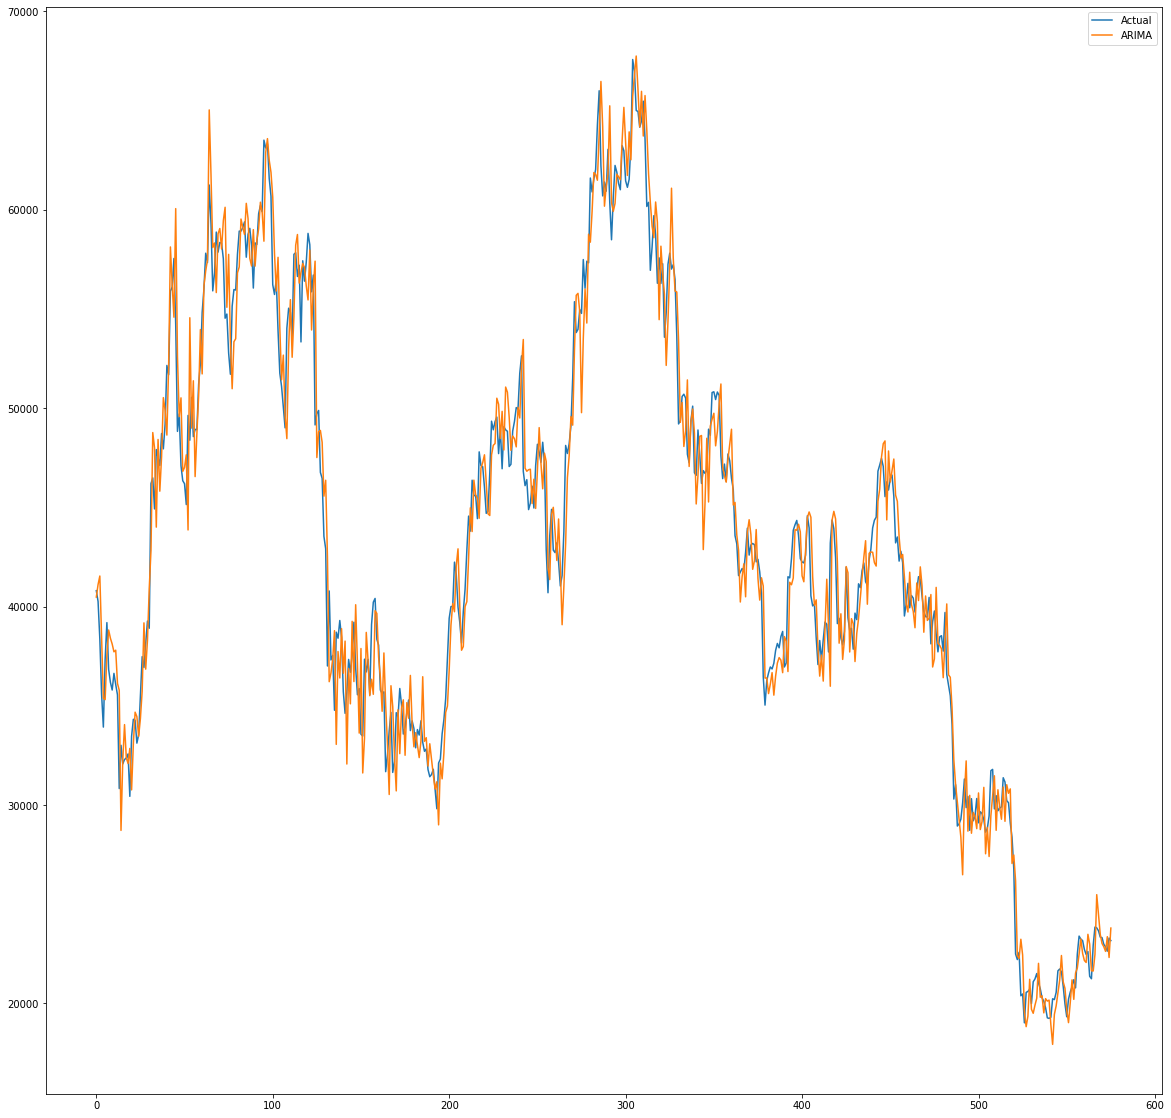

In [9]:
print('ARIMA plot')
plt.plot(testData, label = 'Actual')
plt.plot(ForecastArima, label = 'ARIMA')
plt.legend()

In [10]:
rmseArima = mean_squared_error(testData, ForecastArima, squared = False)
print(f'RMSE ARIMAl {rmseArima}')

RMSE ARIMAl 2006.3580350644927


# DL Models - RNN, LSTM and GRU

## Data Preparation

In [11]:
# function to prepare the data
def prepare_data(data,lookback):
    # generate the input and output sequences
    X_ = []
    Y_ = []

    for i in range(lookback, len(data)):
        X_.append(data[i - lookback: i])
        Y_.append(data[i: i + 1])

    X_ = np.array(X_)
    Y_ = np.array(Y_)
    return(X_,Y_)

In [12]:
# lookback
lb = 2

# train_test_split
# 80% train and 20% test
df = pd.DataFrame(df)
train, test = df.values[:len(df)- testSize - lb], df.values[len(df)- testSize -lb:]

In [13]:
#preparing the train and test data
x_train, y_train = prepare_data(train,lb)
x_test, y_test = prepare_data(test,lb)

# RNN

In [14]:
# callback function to save best weights only
callback_bs = tensorflow.keras.callbacks.ModelCheckpoint(
#     filepath='/content/',
    filepath= 'RNN',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# callback to sstop early
callback_es = [
    tensorflow.keras.callbacks.EarlyStopping(patience=10),
    ]

In [15]:
def modelRNN(X,Y,X_t, Y_t, epochs = 20):
    #callbacks to monitor overfitting

    #initializing the weights
    np.random.seed(1025)
    tensorflow.random.set_seed(1025)

    model = Sequential()
    model.add(SimpleRNN(30, activation='relu', return_sequences=True))
    model.add(SimpleRNN(20, activation='relu', return_sequences=True))
    model.add(SimpleRNN(10, activation='relu', return_sequences=True))
    model.add(SimpleRNN(5, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae', metrics = 'mse')

    history = model.fit(x_train, y_train, epochs=epochs ,batch_size = 3, validation_split=0.2, verbose=2, shuffle=False, validation_data=(X_t, Y_t), callbacks = [callback_es, callback_bs])
    y_p = model.predict(X_t)
    
    return model, history, y_p

In [16]:
modelRNN, historyRNN, predictRNN = modelRNN(x_train, y_train,x_test, y_test, epochs = 100)

Epoch 1/100
614/614 - 10s - loss: 263.2370 - mse: 158989.0312 - val_loss: 324.8524 - val_mse: 288644.7500
Epoch 2/100
614/614 - 3s - loss: 145.4467 - mse: 127270.7812 - val_loss: 314.1695 - val_mse: 272532.6875
Epoch 3/100
614/614 - 3s - loss: 143.0328 - mse: 123247.5078 - val_loss: 321.6382 - val_mse: 282575.0000
Epoch 4/100
614/614 - 3s - loss: 140.8086 - mse: 119463.7734 - val_loss: 295.5872 - val_mse: 243886.2969
Epoch 5/100
614/614 - 3s - loss: 139.8786 - mse: 118188.0078 - val_loss: 296.2524 - val_mse: 246022.1875
Epoch 6/100
614/614 - 3s - loss: 138.4236 - mse: 116834.9219 - val_loss: 290.2121 - val_mse: 236556.2500
Epoch 7/100
614/614 - 3s - loss: 136.7466 - mse: 113737.6484 - val_loss: 285.1425 - val_mse: 228688.2656
Epoch 8/100
614/614 - 3s - loss: 134.8332 - mse: 109724.0000 - val_loss: 289.7417 - val_mse: 236822.3750
Epoch 9/100
614/614 - 3s - loss: 133.5657 - mse: 108596.6719 - val_loss: 283.1956 - val_mse: 227350.2500
Epoch 10/100
614/614 - 3s - loss: 132.4767 - mse: 1076

In [17]:
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 2, 30)             960       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 20)             1020      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 2, 10)             310       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 5)                 80        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 2,376
Trainable params: 2,376
Non-trainable params: 0
_________________________________________________________________


RNN plot


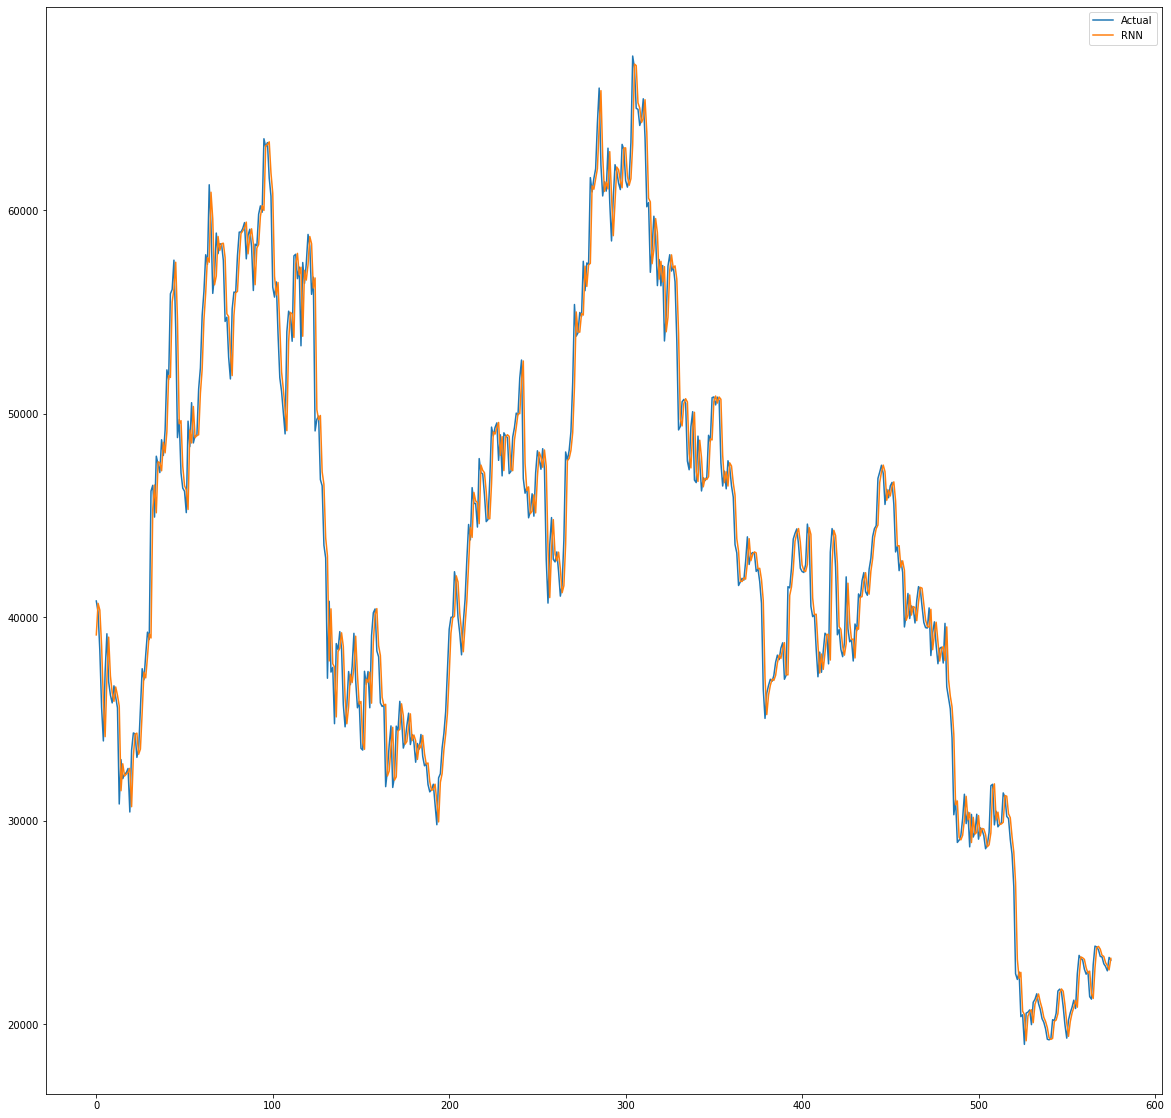

In [18]:
print('RNN plot')
plt.plot(testData, label = 'Actual')
plt.plot(predictRNN, label = 'RNN')
plt.legend()

In [19]:
rmseRNN = mean_squared_error(testData, predictRNN, squared = False)
print(f'RMSE RNN {rmseRNN}')

RMSE RNN 1684.7869135418775


# LSTM

In [20]:
# callback function to save best weights only
callback_bs = tensorflow.keras.callbacks.ModelCheckpoint(
#     filepath='/content/',
    filepath= 'LSTM',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# callback to sstop early
callback_es = [
    tensorflow.keras.callbacks.EarlyStopping(patience=10),
    ]

In [21]:
def modelLSTM(X,Y,X_t, Y_t, epochs = 20):
    #callbacks to monitor overfitting

    #initializing the weights
    np.random.seed(1025)
    tensorflow.random.set_seed(1025)

    model = Sequential()
    model.add(LSTM(30, activation='relu', return_sequences=True))
    model.add(LSTM(20, activation='relu', return_sequences=True))
    model.add(LSTM(10, activation='relu', return_sequences=True))
    model.add(LSTM(5, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae', metrics = 'mse')

    history = model.fit(x_train, y_train, epochs=epochs ,batch_size = 3, validation_split=0.2, verbose=2, shuffle=False, validation_data=(X_t, Y_t), callbacks = [callback_es, callback_bs])
    y_p = model.predict(X_t)
    
    return model, history, y_p

In [22]:
modelLSTM, historyLSTM, predictLSTM = modelLSTM(x_train, y_train,x_test, y_test, epochs =100)

Epoch 1/100
614/614 - 14s - loss: 2880.2854 - mse: 18130730.0000 - val_loss: 7861.8872 - val_mse: 73621456.0000
Epoch 2/100
614/614 - 5s - loss: 1300.2848 - mse: 3727066.2500 - val_loss: 1868.5507 - val_mse: 4550476.5000
Epoch 3/100
614/614 - 5s - loss: 149.0165 - mse: 121563.2422 - val_loss: 347.7032 - val_mse: 325175.7812
Epoch 4/100
614/614 - 5s - loss: 143.0488 - mse: 118428.6719 - val_loss: 390.4484 - val_mse: 287389.1875
Epoch 5/100
614/614 - 4s - loss: 143.9135 - mse: 120069.2891 - val_loss: 394.6885 - val_mse: 288159.0000
Epoch 6/100
614/614 - 5s - loss: 145.2450 - mse: 121194.5625 - val_loss: 304.7786 - val_mse: 254599.7500
Epoch 7/100
614/614 - 5s - loss: 146.5074 - mse: 148568.2188 - val_loss: 295.8888 - val_mse: 210901.4531
Epoch 8/100
614/614 - 5s - loss: 136.7761 - mse: 107089.9766 - val_loss: 312.7240 - val_mse: 217622.4531
Epoch 9/100
614/614 - 5s - loss: 128.4281 - mse: 94696.3750 - val_loss: 342.0690 - val_mse: 239612.8281
Epoch 10/100
614/614 - 5s - loss: 136.4179 - 

In [23]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 30)             3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 20)             4080      
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 10)             1240      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 9,486
Trainable params: 9,486
Non-trainable params: 0
_________________________________________________________________


LSTM plot


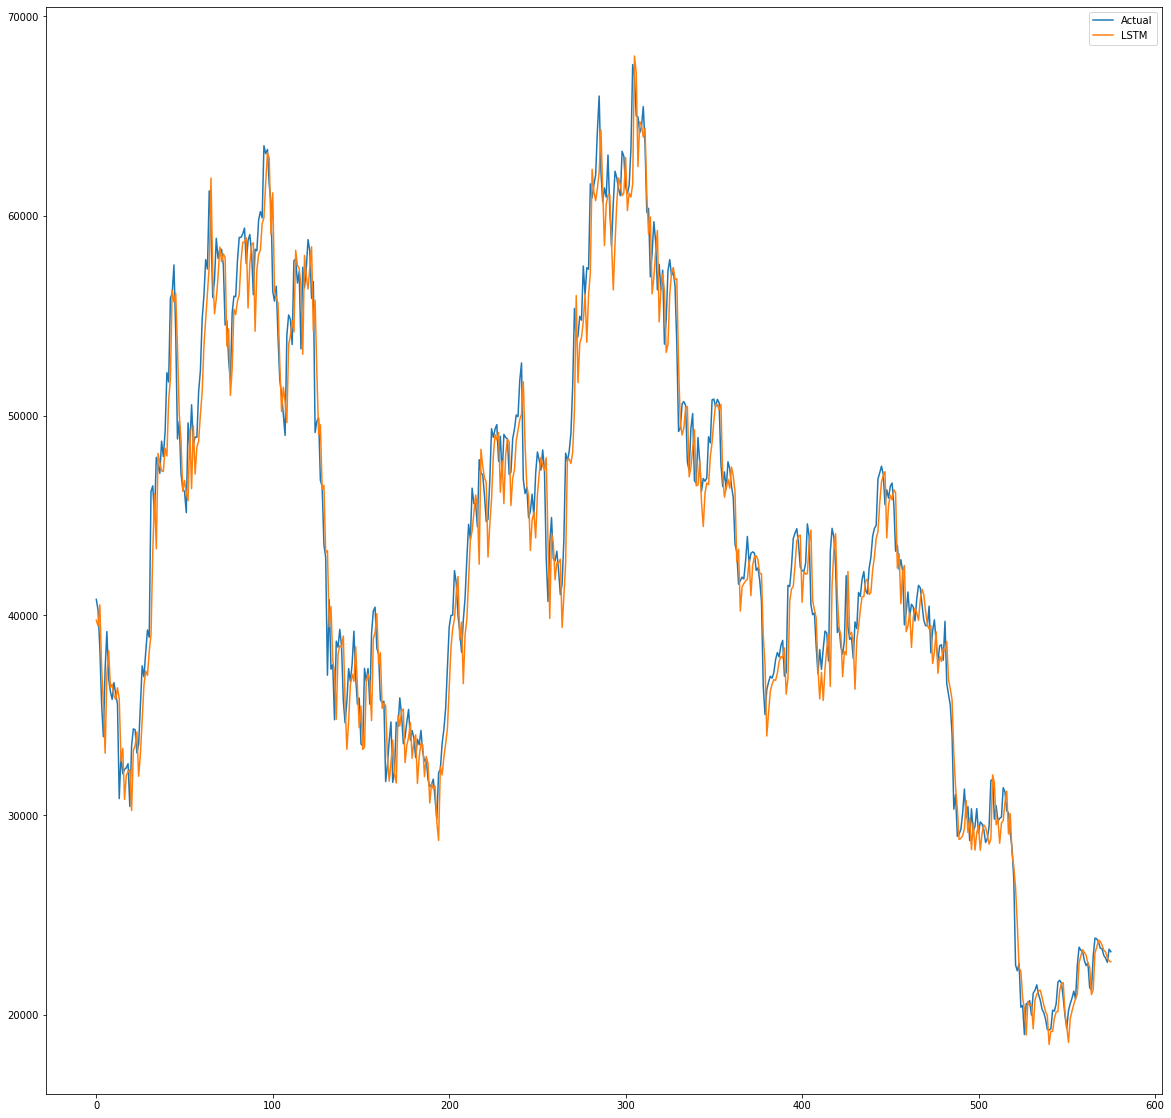

In [24]:
print('LSTM plot')
plt.plot(testData, label = 'Actual')
plt.plot(predictLSTM, label = 'LSTM')
plt.legend()

In [25]:
rmseLSTM = mean_squared_error(testData, predictLSTM, squared = False)
print(f'RMSE RNN {rmseLSTM}')

RMSE RNN 1893.3411450170172


# GRU

In [26]:
# callback function to save best weights only
callback_bs = tensorflow.keras.callbacks.ModelCheckpoint(
#     filepath='/content/',
    filepath= 'GRU',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# callback to sstop early
callback_es = [
    tensorflow.keras.callbacks.EarlyStopping(patience=10),
    ]

In [27]:
def modelGRU(X,Y,X_t, Y_t, epochs = 20):
    #callbacks to monitor overfitting

    #initializing the weights
    np.random.seed(1025)
    tensorflow.random.set_seed(1025)

    model = Sequential()
    model.add(GRU(30, activation='relu', return_sequences=True))
    model.add(GRU(20, activation='relu', return_sequences=True))
    model.add(GRU(10, activation='relu', return_sequences=True))
    model.add(GRU(5, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae', metrics = 'mse')

    history = model.fit(x_train, y_train, epochs=epochs ,batch_size = 3, validation_split=0.2, verbose=2, shuffle=False, validation_data=(X_t, Y_t), callbacks = [callback_es, callback_bs])
    y_p = model.predict(X_t)
    
    return model, history, y_p

In [28]:
modelGRU, historyGRU, predictGRU = modelGRU(x_train, y_train,x_test, y_test, epochs = 100)

Epoch 1/100
614/614 - 16s - loss: 3533.9878 - mse: 27724976.0000 - val_loss: 10609.1680 - val_mse: 133387760.0000
Epoch 2/100
614/614 - 5s - loss: 3188.1594 - mse: 22356758.0000 - val_loss: 9071.9766 - val_mse: 97812616.0000
Epoch 3/100
614/614 - 5s - loss: 2083.1943 - mse: 9402584.0000 - val_loss: 4797.8770 - val_mse: 27884426.0000
Epoch 4/100
614/614 - 5s - loss: 240.4181 - mse: 179598.4062 - val_loss: 359.5080 - val_mse: 350583.2812
Epoch 5/100
614/614 - 5s - loss: 171.9197 - mse: 169865.3438 - val_loss: 359.7978 - val_mse: 351200.4062
Epoch 6/100
614/614 - 5s - loss: 171.8271 - mse: 169702.1875 - val_loss: 360.8360 - val_mse: 353364.1562
Epoch 7/100
614/614 - 5s - loss: 171.4005 - mse: 168500.9062 - val_loss: 360.9993 - val_mse: 353693.0000
Epoch 8/100
614/614 - 5s - loss: 171.3754 - mse: 168451.8438 - val_loss: 361.1560 - val_mse: 354001.0312
Epoch 9/100
614/614 - 3s - loss: 171.4352 - mse: 168605.6562 - val_loss: 360.8432 - val_mse: 353377.8750
Epoch 10/100
614/614 - 3s - loss: 1

In [29]:
modelGRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 30)             2970      
_________________________________________________________________
gru_1 (GRU)                  (None, 2, 20)             3120      
_________________________________________________________________
gru_2 (GRU)                  (None, 2, 10)             960       
_________________________________________________________________
gru_3 (GRU)                  (None, 5)                 255       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 7,311
Trainable params: 7,311
Non-trainable params: 0
_________________________________________________________________


GRU plot


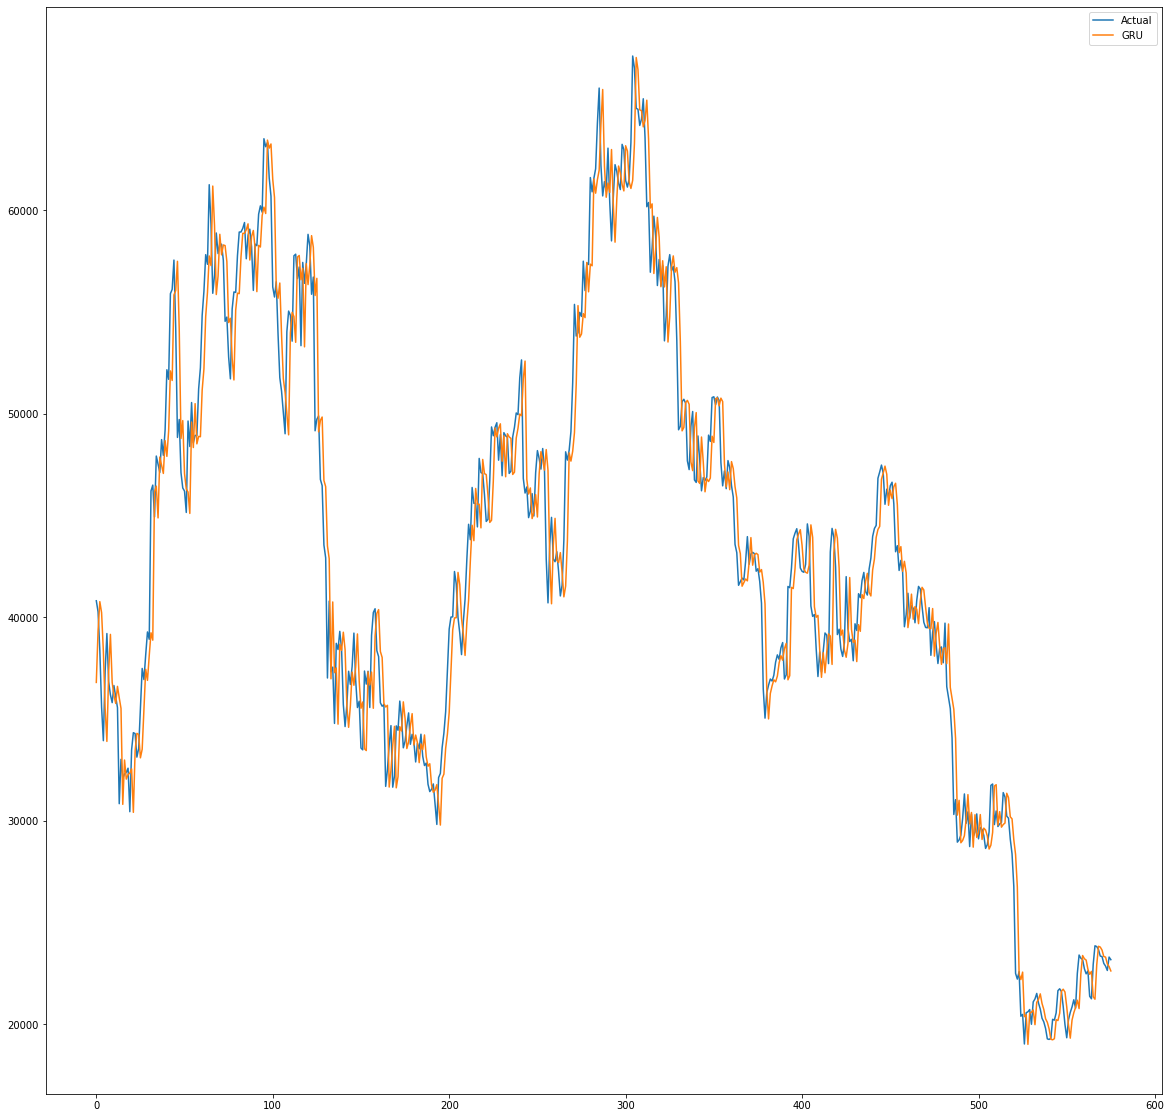

In [30]:
print('GRU plot')
plt.plot(testData, label = 'Actual')
plt.plot(predictGRU, label = 'GRU')
plt.legend()

In [31]:
rmseGRU = mean_squared_error(testData, predictGRU, squared = False)
print(f'RMSE GRU {rmseGRU}')

RMSE GRU 2327.4108713610653


# Comparison

Comparison plot


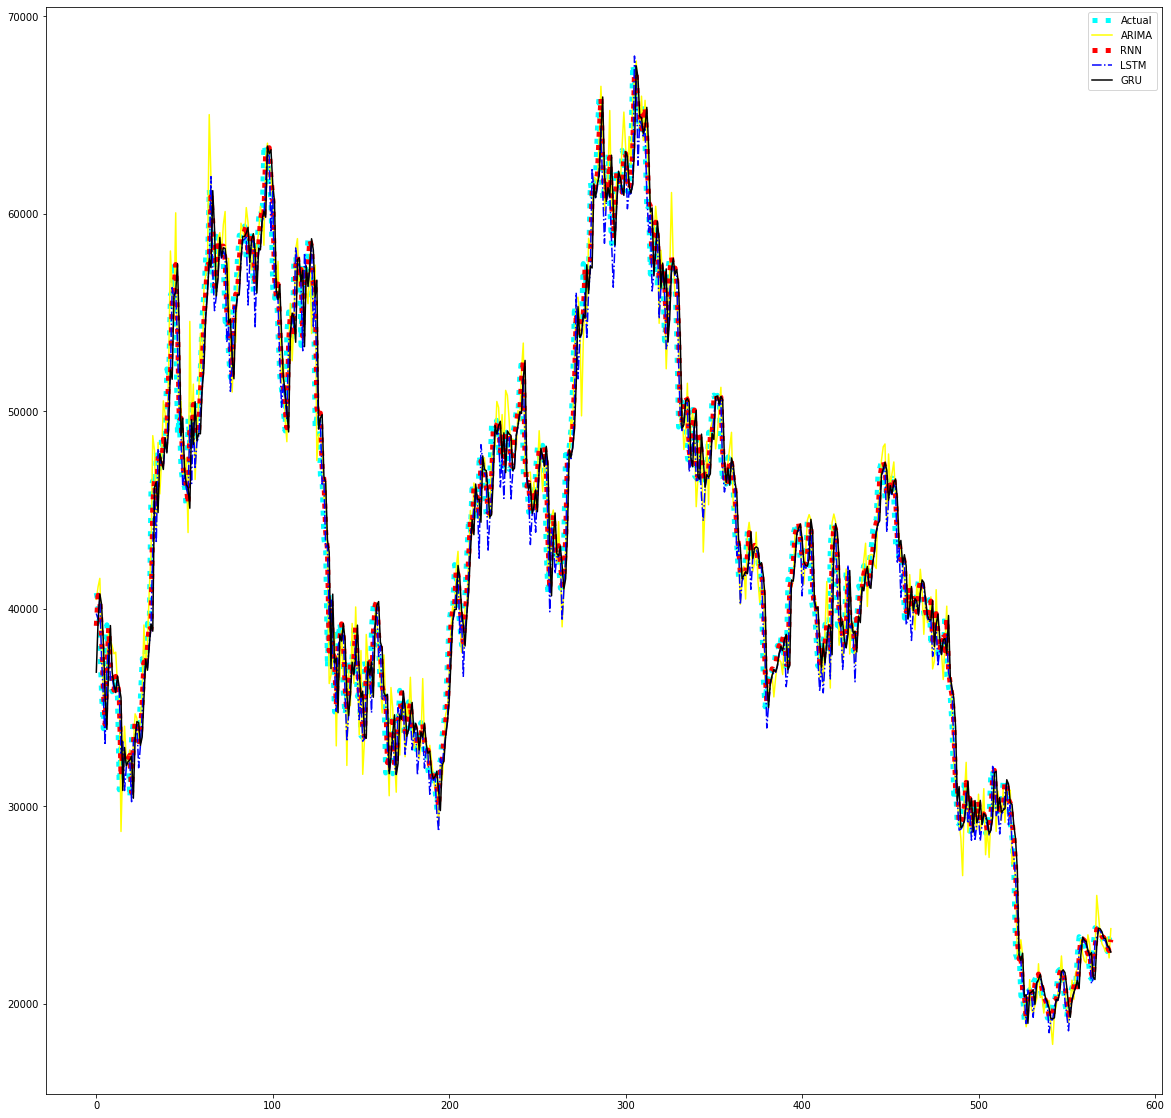

In [32]:
print('Comparison plot')
plt.plot(testData, label = 'Actual', linestyle='dotted', linewidth = 5, color = 'cyan')
plt.plot(ForecastArima, label = 'ARIMA', color = 'yellow')
plt.plot(predictRNN, label = 'RNN', linestyle='dotted', linewidth = 5, color = 'red')
plt.plot(predictLSTM, label = 'LSTM',linestyle = 'dashdot', color = 'blue')
plt.plot(predictGRU, label = 'GRU', color = 'black')
plt.legend()

In [33]:
# making a RMSE dataframe
rmse = {'rmseGRU': rmseGRU, 'rmseLSTM': rmseLSTM, 'rmseARIMA': rmseArima, 'rmseRNN': rmseRNN}
rmse = pd.DataFrame(rmse.values(), index = rmse.keys(), columns = ['RMSE'])
rmse = rmse.sort_values(by = 'RMSE')
rmse

,RMSE
rmseRNN,1684.786914
rmseLSTM,1893.341145
rmseARIMA,2006.358035
rmseGRU,2327.410871


RMSE perfroms the best followed by LSTM, ARIMA, and GRU respectively

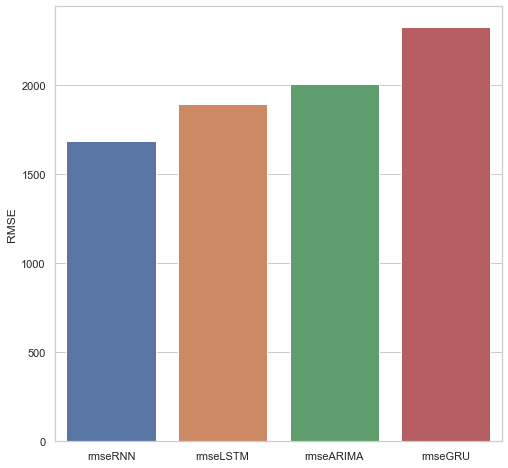

In [34]:
plt.rcParams["figure.figsize"] = (8,8)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=rmse.index, y= rmse['RMSE'])